PyMC paper/tutorial is the reference.

Salvatier J, Wiecki TV, Fonnesbeck C. 2016. _Probabilistic programming in Python using PyMC3_. PeerJ Computer Science 2:e55 https://doi.org/10.7717/peerj-cs.55

* Can implement MCMC sampling algorithms No-U-Turn Sampler (NUTS) and a self-tuning variant of HMC.
* PyMC3, Stan and LaplacesDemon package for R are currently the only probabilistic programming languages to offer HMC.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import scipy as sp
import arviz as az

Consider a simple model:

\begin{align}
Y = \alpha + \beta_1 X_1 + \beta_2 X_2 + \epsilon \text{ s.t. } \epsilon \sim \mathcal{N}(\mu, \sigma^2) \\
\alpha, \beta_1, \beta_2 \sim \mathcal{N}(0,10) \\
\sigma \sim |\mathcal{N}(0,1)|
\end{align}

Goal: Estimate expected response values.

### Step 1: Model specification
Define the model using `pm.Model()` object followed by a `with` statement.

In [9]:
# simulate data from a simple linear model
# true parameter values
alpha, sigma = 1,1
beta = [1,2.5]

# data size
size = 100

# simulate predictor values
X1 = np.linspace(0,1,size)
X2 = np.linspace(0,0.2, size)

In [10]:
# simulate response values
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma # randn corresponds to N(0,1) draw
print(type(Y))
Y.shape

<class 'numpy.ndarray'>


(100,)

In [11]:
# create a Model object to act as container for model RVs
basic_model = pm.Model()

# use with statement to create a model context manager
# use this context manager to introduce PyMC objects to the model
with basic_model:
    # define model parameter priors
    alpha = pm.Normal("alpha", mu = 0, sigma = 10)
    beta = pm.MvNormal("beta", mu = np.zeros(2), cov = np.array([[1,0],[0,1]]))
    sigma = pm.HalfNormal("sigma", sigma = 1)

    # expected outcome i.e. mu = E[Y] 
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # model likelihood
    Y_obs = pm.Normal("Y_obs", mu = mu, sigma = sigma, observed = Y)

### Step 2: Posterior estimation
There are two approaches to estimate unknown parameters using posterior probabilities:
1. Maximum a posteriori (MAP) estimation using optimization methods. Implemented using `pm.find_MAP` in PyMC.
2. compute summaries based on samples drawn from posterior distribution using MCMC methods.

In [12]:
# MAP = mode of the posterior distribution
map_estimate = pm.find_MAP(model = basic_model)
# returns a dict object
print(type(map_estimate))
print(map_estimate)

Output()

<class 'dict'>
{'alpha': array(0.96405262), 'beta': array([1.28708299, 0.2574166 ]), 'sigma_log__': array(-0.09784578), 'sigma': array(0.90678874)}


The function `pm.find_MAP` uses the BFGS optimization algorithm to find maximum of the log-posterior. 

We can choose a different optimization algorithm, if we want to. We can pick one of the optimization algorithms from `scipy.optimize` using `fmin` argument. 

In [13]:
map_estimate2 = pm.find_MAP(model=basic_model, method='powell')
print(map_estimate2)

Output()

/home/padmaraga/anaconda3/envs/bayes/lib/python3.12/site-packages/pymc/tuning/starting.py:176: RuntimeWarning: 
Method powell does not use gradient information (jac).
  opt_result = minimize(

{'alpha': array(0.96466551), 'beta': array([1.29644157, 0.22555264]), 'sigma_log__': array(-0.09843744), 'sigma': array(0.90625239)}


* Although MAP estimates are fast and easy to obtain, the MAP estimates are not always reasonable. 
* Most techniques of finding the MAP estimate find a local minimum that may or may not be enough for the problem at hand. 
* There us no way of estimate uncertainties associated with MAP estimates.
* A better approach would be to use simulation based methods i.e. MCMC algorithms.

To implement MCMC algorithms, use the `pm.step_methods` module. This module lets the users create `step_method` objects that correspond to single iteration of a particular MCMC algorithm. 

PyMC's `pm.step_methods` modules has the following samplers or gradient based sampling methods: 
1. `NUTS` - PyMC's most capable step method.
2. `Metropolis`
3. `Slice`
4. `HamiltonianMC`
5. `BinaryMetropolis`

### Step 3: Sample from posterior

NUTS is especially useful for sampling from models that have many continuous parameters, a situation where older MCMC algorithms work very slowly.NUTS cannot be used on discrete random variables involved in the analysis.

Note that sampling from the posterior must be performed inside the context of the model.

In [15]:
with basic_model:

    # use MAP estimate to initiate sampling
    init_val = pm.find_MAP(method="powell")

    # instantiate sampling
    step = pm.NUTS()

    # draw samples from posterior distribution 
    # returns a trace type object
    trace = pm.sample(draws=2000, step=step, start=init_val)

Output()

/home/padmaraga/anaconda3/envs/bayes/lib/python3.12/site-packages/pymc/tuning/starting.py:176: RuntimeWarning: 
Method powell does not use gradient information (jac).
  opt_result = minimize(

/tmp/ipykernel_10632/3332759308.py:10: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(draws=2000, step=step, start=init_val)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


In [17]:
print(type(trace))
print(dir(trace))

<class 'arviz.data.inference_data.InferenceData'>
['InferenceDataItemsView', 'InferenceDataValuesView', '__abstractmethods__', '__add__', '__annotations__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__setattr__', '__setitem__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_attrs', '_group_names', '_groups', '_groups_all', '_groups_warmup', '_repr_html_', '_wrap_xarray_method', 'add_groups', 'assign', 'assign_coords', 'attrs', 'chunk', 'close', 'compute', 'copy', 'cumsum', 'extend', 'from_datatree', 'from_netcdf', 'from_zarr', 'get', 'get_index', 'groups', 'isel', 'i

The trace object of type `arviz.data.inference_data.InferenceData` is used to store and analyze the results of Bayesian inference.

In [21]:
# some common ways of working with trace objects requires arviz module
trace_summary = az.summary(data = trace)
trace_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.967,0.176,0.625,1.288,0.003,0.002,4269.0,4615.0,1.0
beta[0],1.281,0.353,0.601,1.926,0.006,0.004,3549.0,4363.0,1.0
beta[1],0.252,0.974,-1.625,2.010,0.014,0.011,5183.0,5291.0,1.0
sigma,0.927,0.066,0.804,1.046,0.001,0.001,6635.0,5174.0,1.0


In [26]:
# accessing data from trace object
posterior_samples = trace.posterior
print(type(posterior_samples))

<class 'xarray.core.dataset.Dataset'>


In [27]:
posterior_samples

<xarray.Dataset> Size: 272kB
Dimensions:     (chain: 4, draw: 2000, beta_dim_0: 2)
Coordinates:
  * chain       (chain) int64 32B 0 1 2 3
  * draw        (draw) int64 16kB 0 1 2 3 4 5 ... 1994 1995 1996 1997 1998 1999
  * beta_dim_0  (beta_dim_0) int64 16B 0 1
Data variables:
    alpha       (chain, draw) float64 64kB 0.8884 1.032 1.084 ... 0.8825 1.058
    beta        (chain, draw, beta_dim_0) float64 128kB 1.354 0.1999 ... -0.7755
    sigma       (chain, draw) float64 64kB 0.9456 0.9599 0.9296 ... 1.083 0.9931
Attributes:
    created_at:                 2024-12-29T19:37:17.393944+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.19.1
    sampling_time:              6.047230243682861
    tuning_steps:               1000

In [29]:
# Accessing a specific variable
alpha_samples = trace.posterior['alpha']
print(type(alpha_samples))

<class 'xarray.core.dataarray.DataArray'>


In [30]:
alpha_samples

<xarray.DataArray 'alpha' (chain: 4, draw: 2000)> Size: 64kB
array([[0.88837118, 1.03158742, 1.08390593, ..., 0.7287307 , 0.85899325,
        0.84696083],
       [1.274999  , 1.23044159, 1.24913074, ..., 0.96617473, 0.79503905,
        0.80553343],
       [0.90923942, 1.07957467, 0.92913662, ..., 1.00677037, 1.01931969,
        1.15034593],
       [1.07517298, 1.10827056, 0.86504645, ..., 0.88143291, 0.88245141,
        1.05842446]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 16kB 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999

In [32]:
# Saving and Loading the Trace object

# Saving the trace
az.to_netcdf(trace, 'trace.nc')

# Loading the trace
loaded_trace = az.from_netcdf('trace.nc')
print(type(loaded_trace))

<class 'arviz.data.inference_data.InferenceData'>


Converting to `trace` object to Pandas DataFrame

In [38]:
df_trace = trace.posterior.to_dataframe()
print(df_trace.head())

                          alpha      beta     sigma
chain draw beta_dim_0                              
0     0    0           0.888371  1.353964  0.945554
           1           0.888371  0.199938  0.945554
      1    0           1.031587  1.250251  0.959851
           1           1.031587  0.605374  0.959851
      2    0           1.083906  1.013720  0.929617


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

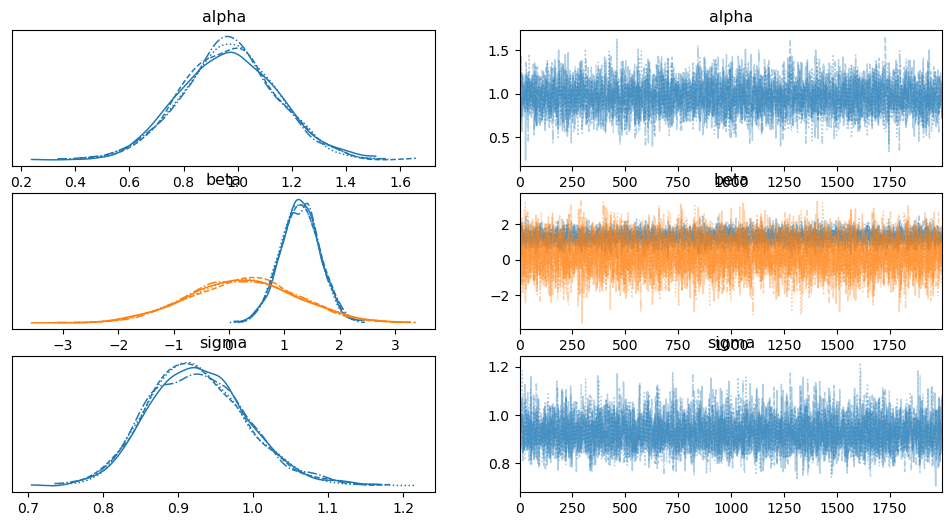

In [22]:
# trace plot
az.plot_trace(data = trace)

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta\n0'}>,
       <Axes: title={'center': 'beta\n1'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

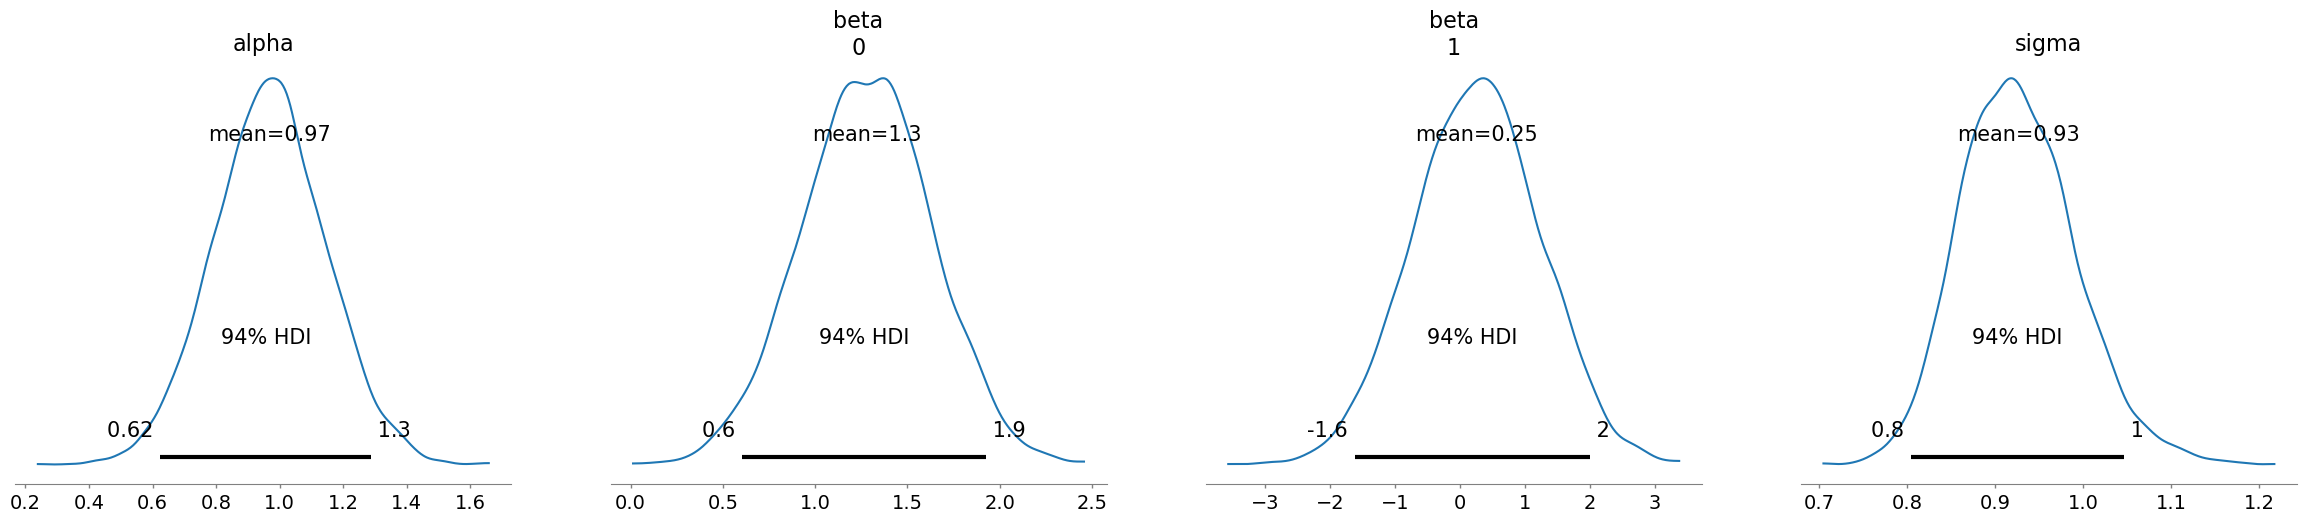

In [23]:
# plot posterior density
az.plot_posterior(trace)

array([[<Axes: title={'center': 'alpha\n0'}>,
        <Axes: title={'center': 'alpha\n1'}>,
        <Axes: title={'center': 'alpha\n2'}>,
        <Axes: title={'center': 'alpha\n3'}>],
       [<Axes: title={'center': 'beta\n0, 0'}>,
        <Axes: title={'center': 'beta\n0, 1'}>,
        <Axes: title={'center': 'beta\n1, 0'}>,
        <Axes: title={'center': 'beta\n1, 1'}>],
       [<Axes: title={'center': 'beta\n2, 0'}>,
        <Axes: title={'center': 'beta\n2, 1'}>,
        <Axes: title={'center': 'beta\n3, 0'}>,
        <Axes: title={'center': 'beta\n3, 1'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n2'}>,
        <Axes: title={'center': 'sigma\n3'}>]], dtype=object)

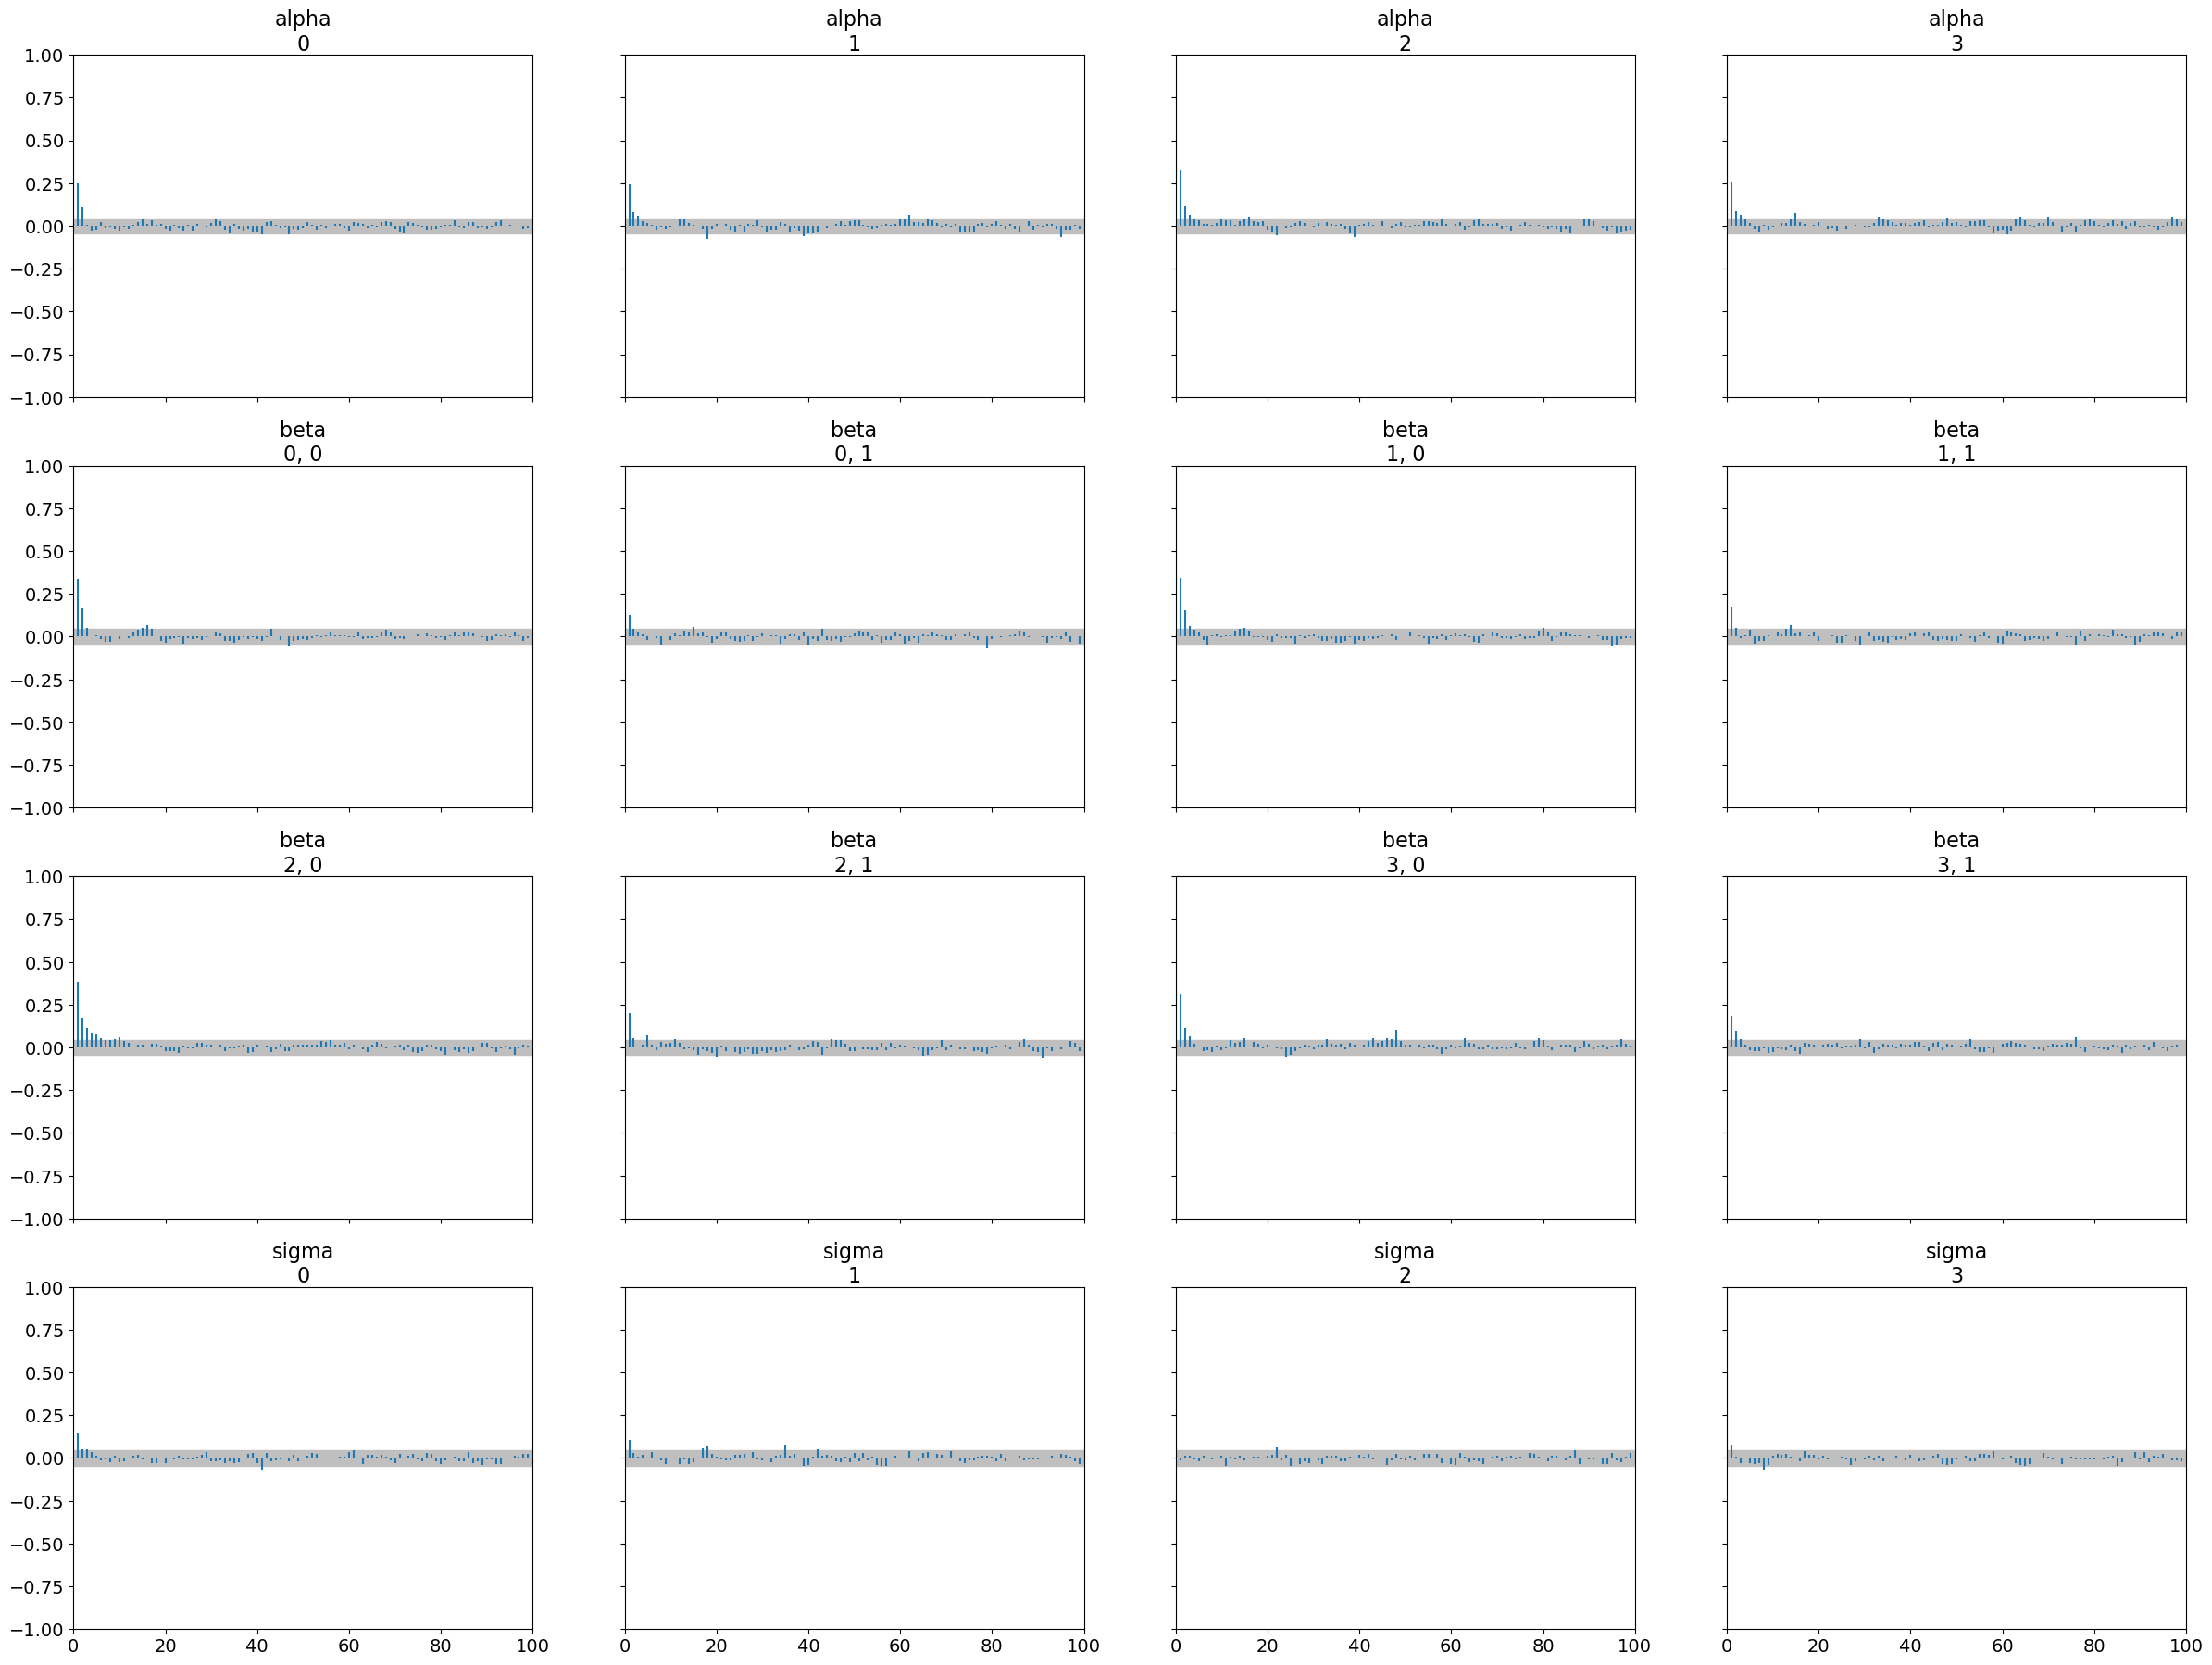

In [24]:
# acf plot
az.plot_autocorr(trace)

array([[<Axes: ylabel='beta\n0'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta\n1'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='alpha', ylabel='sigma'>, <Axes: xlabel='beta\n0'>,
        <Axes: xlabel='beta\n1'>]], dtype=object)

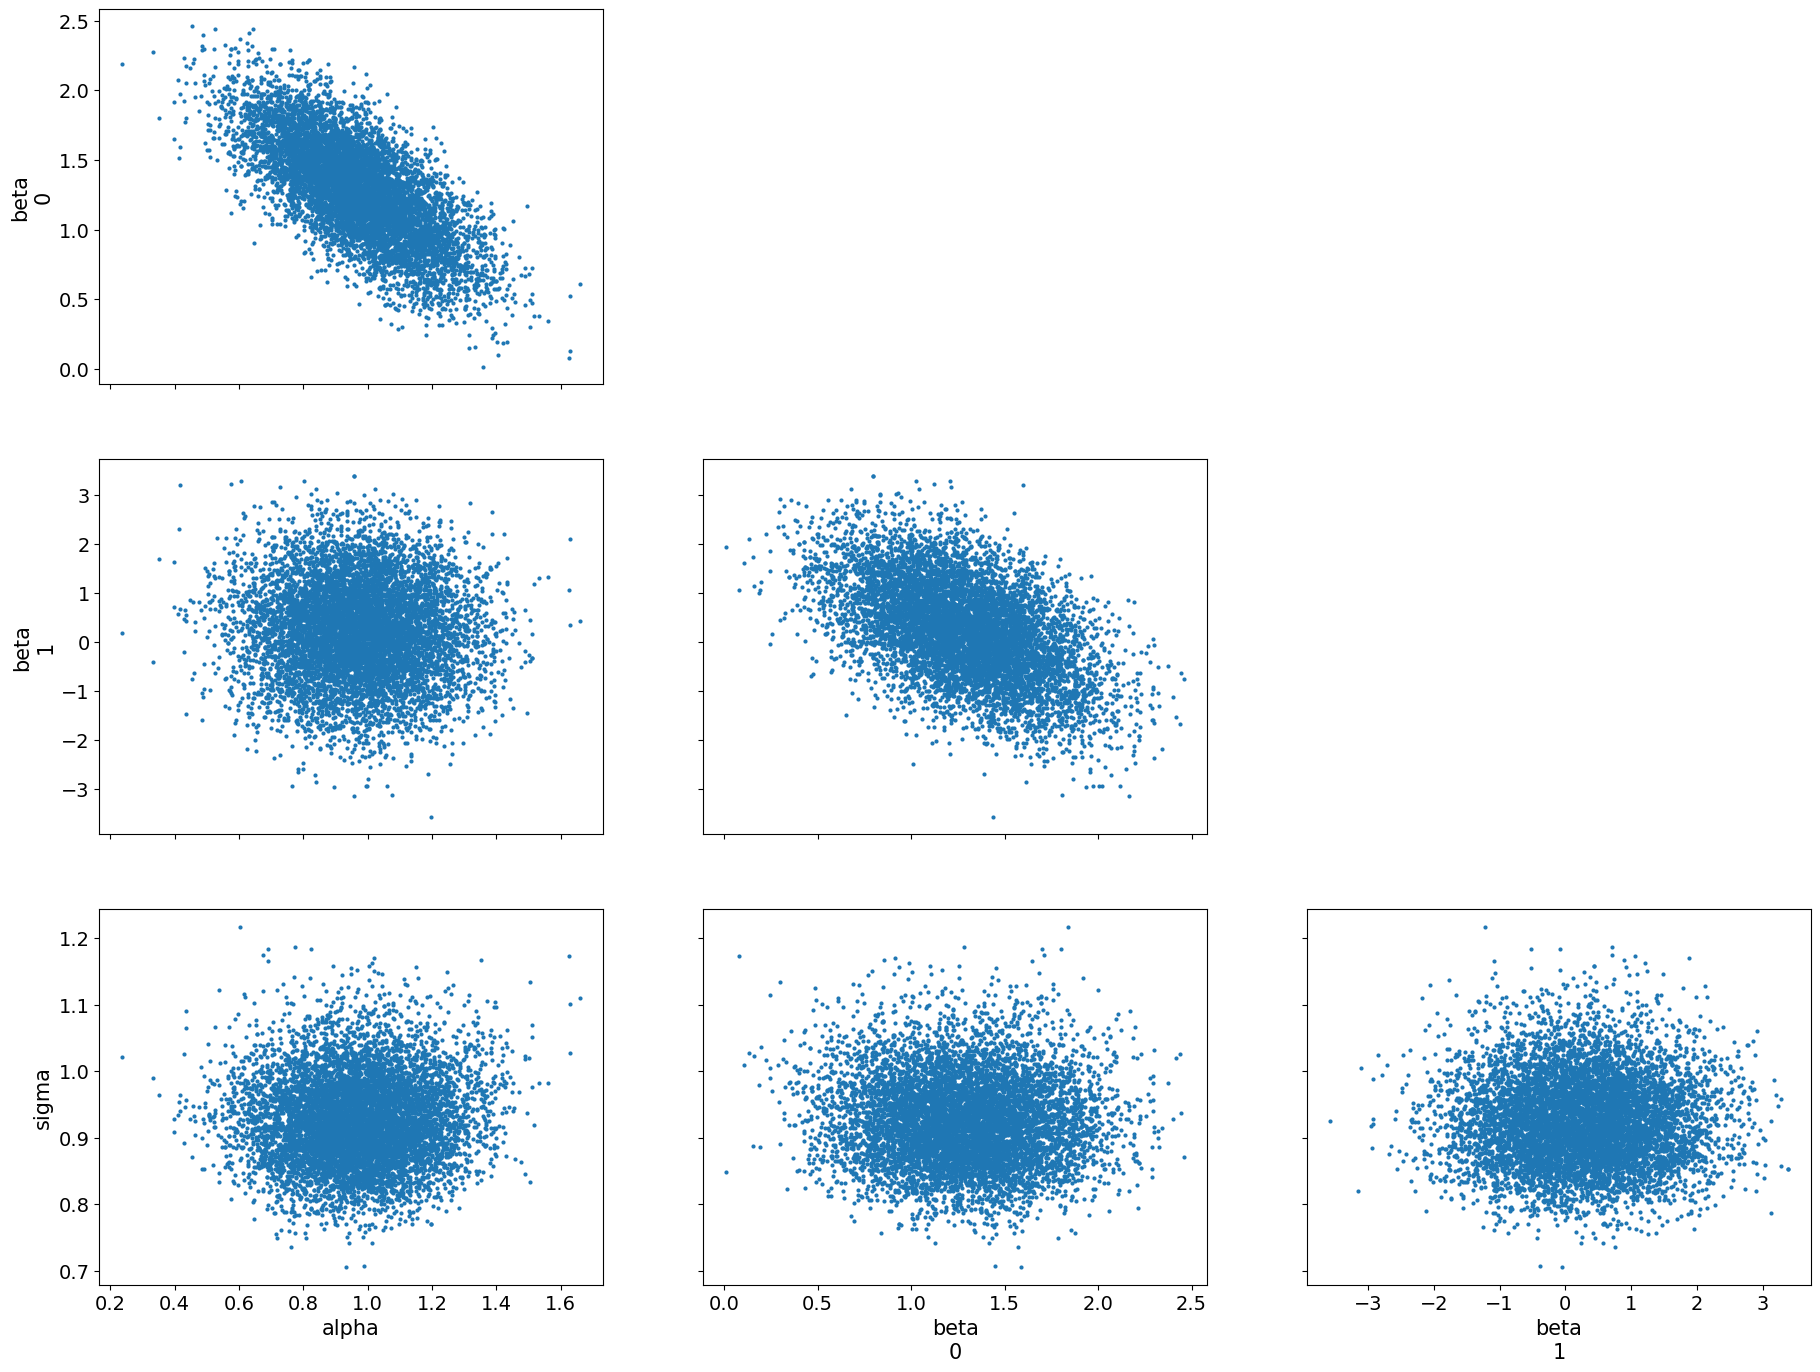

In [25]:
# pair plot
az.plot_pair(trace)